# Importing Modules

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, MobileNet
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Directory Path

In [42]:
# Setting the directory path
data_dir = r'C:\Users\saite\OneDrive\Desktop\final project\archive'

In [43]:

# Displaying some sample images
def show_sample_images(generator, num_images=10):
    classes = list(generator.class_indices.keys())

    # Getting a batch of images and labels from the generator
    images, labels = next(generator)

    # Plotting the images with labels
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(classes[int(labels[i].argmax())])
        plt.axis('off')
        plt.show()
    
# Displaying sample images from the training generator
def main():
    Show_sample_images(train_gen)


# Data Preprocessing

In [44]:
# Creating a list to store file paths and labels
filepaths = []
labels = []

# Evaluating the directory to get file paths and labels
for root, dirs, files in os.walk(data_dir):
    for klass in dirs:
        if klass in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        classpath = os.path.join(root, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

In [45]:
# Creating a DataFrame
data_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Displaying class distribution
print(data_df['labels'].value_counts())

lung_aca                5000
lung_n                  5000
lung_scc                5000
colon_aca               5000
colon_n                 5000
lung_colon_image_set       1
Name: labels, dtype: int64


In [46]:
# Sampling the data to balance classes and use a smaller subset
sample_size = 500
sample_list = []
group = data_df.groupby('labels')
for label in data_df['labels'].unique():    
    label_group = group.get_group(label).sample(sample_size, replace=True, random_state=123, axis=0)    
    sample_list.append(label_group)
df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

3000


# Training and Testing

In [47]:
# Splitting the data into train, test, and validation sets
train_split = 0.8
test_split = 0.1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

# Displaying data split lengths
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))

train_df length: 2400 test_df length: 300 valid_df length: 300


# Setting Parameters

In [48]:
# Image parameters
height = 64  # Reduced image height
width = 64   # Reduced image width
channels = 3
batch_size = 32
img_size = (height, width)

In [49]:
# Data augmentation and scaling
gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_gen = gen.flow_from_dataframe(train_df, directory=None, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical', batch_size=batch_size, subset='training')
valid_gen = gen.flow_from_dataframe(valid_df, directory=None, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical', batch_size=batch_size, subset='validation')
test_gen = gen.flow_from_dataframe(test_df, directory=None, x_col='filepaths', y_col='labels',
                                   target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

Found 1791 validated image filenames belonging to 5 classes.
Found 25 validated image filenames belonging to 5 classes.


C:\Users\saite\AppData\Roaming\Python\Python39\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 410 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
C:\Users\saite\AppData\Roaming\Python\Python39\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 45 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 255 validated image filenames belonging to 5 classes.


C:\Users\saite\AppData\Roaming\Python\Python39\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 45 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


# Xception and MobileNet Model

In [50]:
# Building a model with Xception and MobileNet
input_layer = Input(shape=(height, width, channels))
xception = Xception(weights='imagenet', include_top=False)(input_layer)
mobilenet = MobileNet(weights='imagenet', include_top=False)(input_layer)
concatenated = Concatenate()([xception, mobilenet])
flat = Flatten()(concatenated)
dense = Dense(units=1024, activation='relu')(flat)
dense = Dense(512, activation='relu')(dense)
dense = Dense(units=256, activation='relu')(dense)
predictions = Dense(5, activation='softmax')(dense)

# Model Summury

In [51]:
# Compiling the model
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# Displaying the model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 xception (Functional)       (None, None, None, 2048)     2086148   ['input_7[0][0]']             
                                                          0                                       
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, None, None, 1024)     3228864   ['input_7[0][0]']             
 onal)                                                                                            
                                                                                            

# Evaluating Model

In [53]:
# Trainning the model with early stopping
history = model.fit(train_gen, epochs=10, validation_data=valid_gen, verbose=1, callbacks=[keras.callbacks.EarlyStopping(patience=3)])

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Saving the model
model_name = 'Xception+MobileNet'
model.save(f'{model_name}_model.h5')

Epoch 1/10
56/56 [==============================] - 140s 2s/step - loss: 0.8130 - accuracy: 0.7901 - val_loss: 4.2511 - val_accuracy: 0.6000
Epoch 2/10
56/56 [==============================] - 82s 1s/step - loss: 0.2378 - accuracy: 0.9196 - val_loss: 1.1843 - val_accuracy: 0.6400
Epoch 3/10
56/56 [==============================] - 82s 1s/step - loss: 0.1748 - accuracy: 0.9397 - val_loss: 0.0462 - val_accuracy: 1.0000
Epoch 4/10
56/56 [==============================] - 83s 1s/step - loss: 0.1487 - accuracy: 0.9514 - val_loss: 0.7710 - val_accuracy: 0.9200
Epoch 5/10
56/56 [==============================] - 115s 2s/step - loss: 0.1379 - accuracy: 0.9643 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 6/10
56/56 [==============================] - 84s 1s/step - loss: 0.1375 - accuracy: 0.9693 - val_loss: 0.0385 - val_accuracy: 1.0000
Epoch 7/10
56/56 [==============================] - 87s 1s/step - loss: 0.1730 - accuracy: 0.9598 - val_loss: 1.1561 - val_accuracy: 0.9200
Epoch 8/10
56/56 [

C:\Users\saite\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Training and Validation data

In [54]:
def plot_training_history(history):
    # Plotting the training and validation data
    plt.figure(figsize=(12, 6))

    # Plotting training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

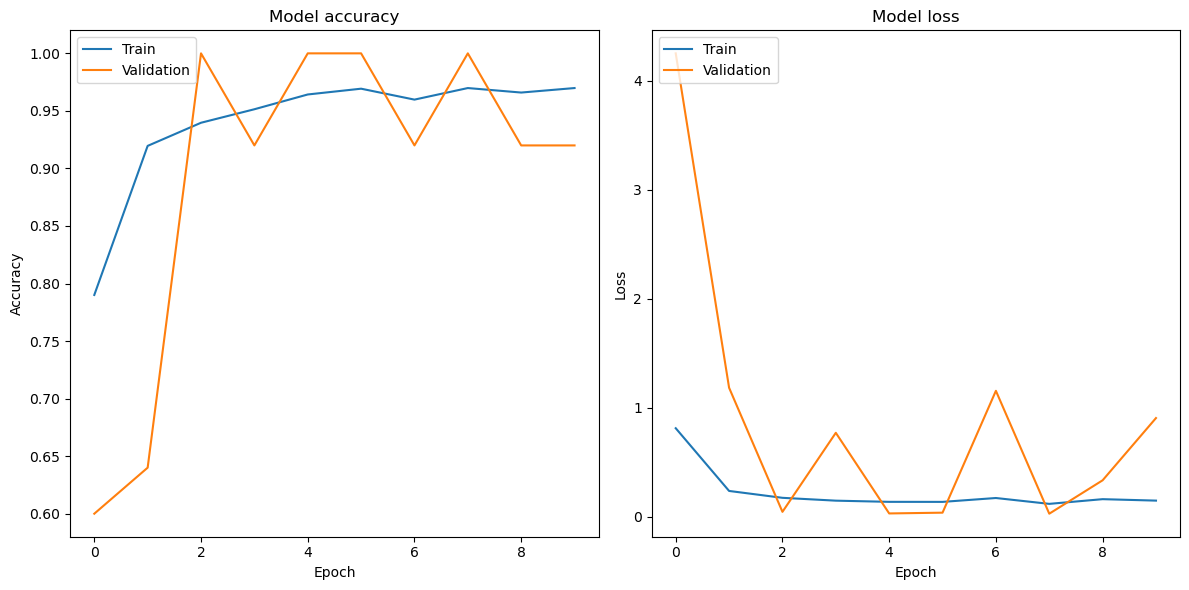

8/8 [==============================] - 7s 630ms/step - loss: 0.7153 - accuracy: 0.8745
Test accuracy: 87.45%


In [55]:
# Plotting the training and validation data
plot_training_history(history)

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Prediction of Images

1/1 [==============================] - 12s 12s/step


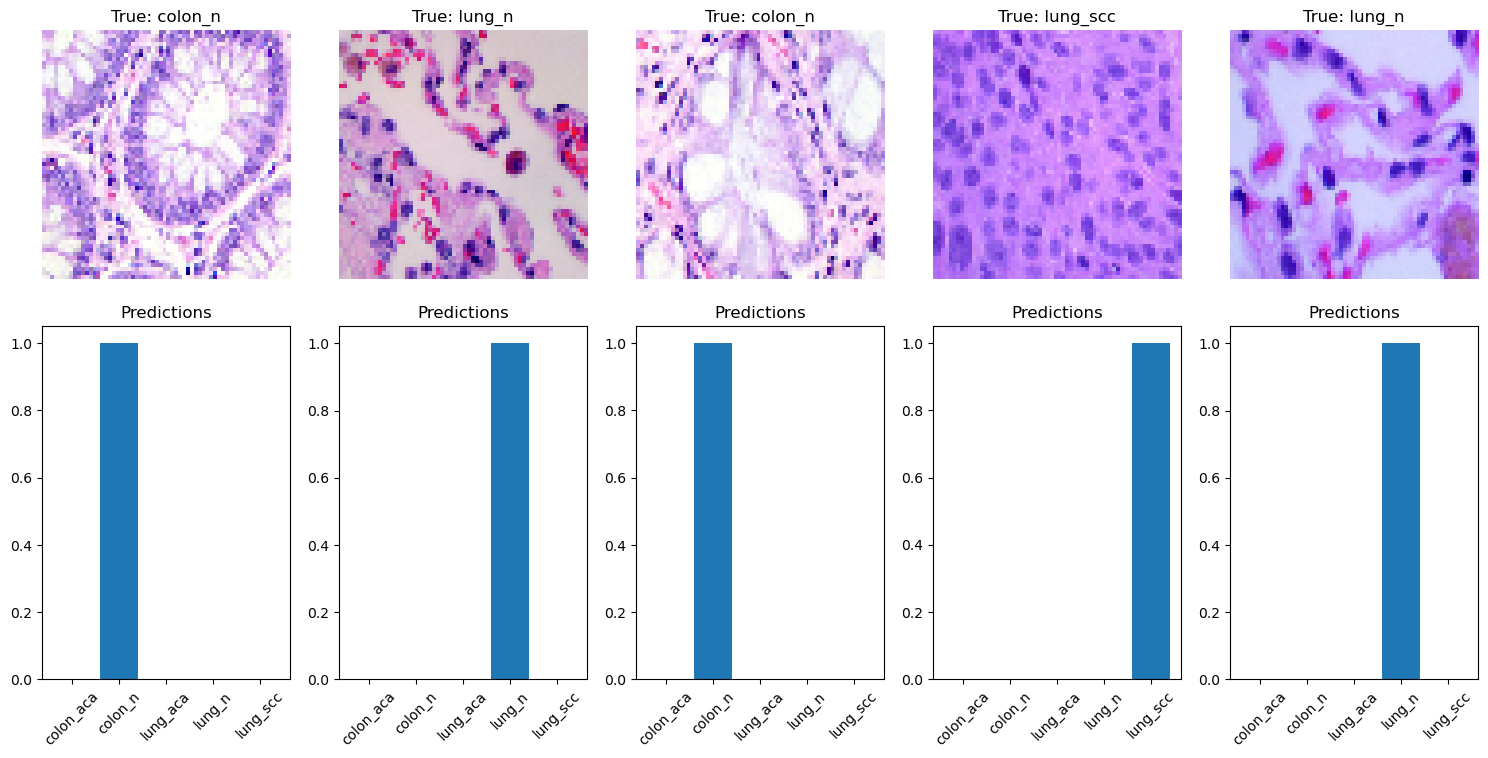

In [56]:
# Plotting a few sample predictions
def show_sample_predictions(gen, model, num_samples=5):
    classes = list(gen.class_indices.keys())
    
    # Getting a sample batch from the generator
    images, labels = next(gen)

    # Making predictions
    predictions = model.predict(images)

    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {classes[np.argmax(labels[i])]}')
        plt.axis('off')

        plt.subplot(2, num_samples, i + num_samples + 1)
        plt.bar(classes, predictions[i])
        plt.title('Predictions')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Showing sample predictions on the validation set
show_sample_predictions(valid_gen, model)

# Confusion Matrix and Accuracy

In [57]:
# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Function to plot a classification report
def plot_classification_report(y_true, y_pred, classes):
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [58]:
# Function to plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

8/8 [==============================] - 7s 645ms/step - loss: 0.7153 - accuracy: 0.8745
Test accuracy: 87.45%
8/8 [==============================] - 15s 685ms/step


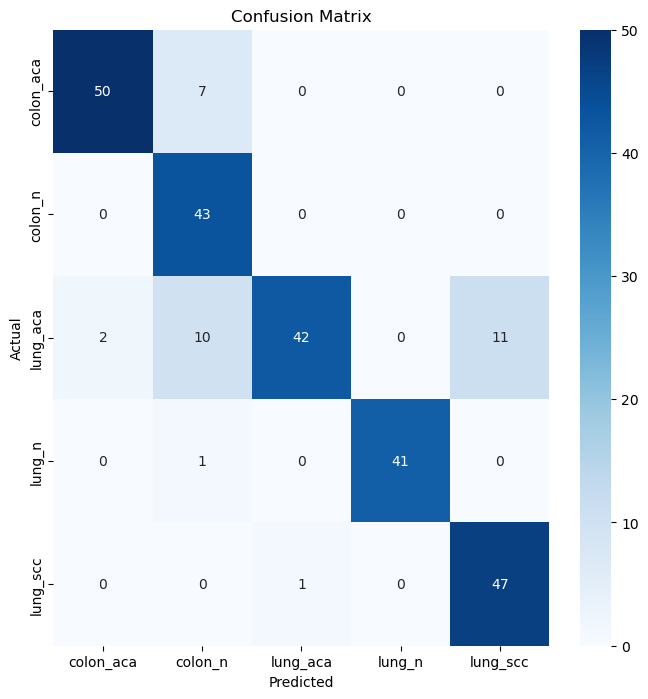

In [59]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'Test accuracy: {test_acc * 100:.2f}%')

# Generating predictions on the test set
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = [np.argmax(prob) for prob in y_pred_probs]

# Plotting confusion matrix and classification report
classes = list(test_gen.class_indices.keys())
plot_confusion_matrix(y_true, y_pred, classes)


# Classification Report

In [60]:
plot_classification_report(y_true, y_pred, classes)

Classification Report:
----------------------
               precision    recall  f1-score   support

   colon_aca       0.96      0.88      0.92        57
     colon_n       0.70      1.00      0.83        43
    lung_aca       0.98      0.65      0.78        65
      lung_n       1.00      0.98      0.99        42
    lung_scc       0.81      0.98      0.89        48

    accuracy                           0.87       255
   macro avg       0.89      0.90      0.88       255
weighted avg       0.90      0.87      0.87       255

